In [ ]:
!pip install tensorflow==1.14

In [ ]:
!git clone https://github.com/rslim087a/track

# use the driving simulator from Udacity to generate your own driving log. (https://github.com/udacity/self-driving-car-sim)

fatal: destination path 'track' already exists and is not an empty directory.


In [ ]:
!ls track

driving_log.csv  IMG


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten , Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa 
import cv2
import pandas as pd
import ntpath
import random

In [ ]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1) # to see the whole column width (no data overflow)
data.head() # showing the first 5 rows

In [ ]:
# to have a shorter directory shown in the data we will use the library ntpath

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


<BarContainer object of 25 artists>

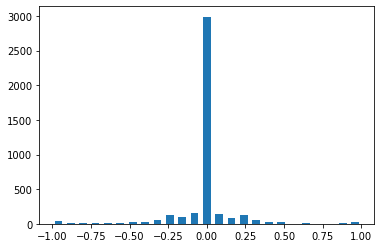

In [ ]:
# visulizing our data to notice the flaws

num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
print(bins) # as we see it goeas from -1 to 1 which make sense but it is not centered with value of 0

# to solve this :
# center = (bins[first element till the end exluding the last element] + bins[2nd element till the end including last element]) * 0.5
# we multiplied bu 0.5 because after the addition elements in between were doubled 

center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
# notice now that it is centered around 0.0

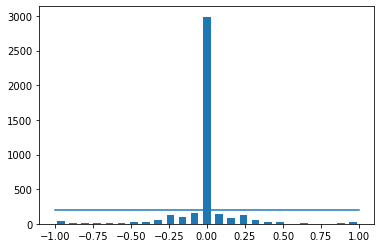

In [ ]:
# notice that the right and the left are nearly balanced which means it is good because there will be no bias
# but as we see there is a lot of zero angle steering ! which could bias the model to predict 0 angle
# so we will reject all the samples above a certain threshold which is 400

num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

#notice the new blue line where any data above will be rejected 

total data:  4053
removed:  2790
remaining:  1263


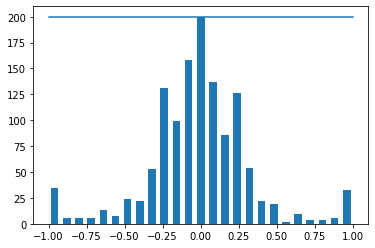

In [ ]:
# in this project we need to apply many preprocessing technniques 
print('total data: ', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [ ]:
# no we want to split our training and validation data

# first let is check on row of data to have a better understanding
print(data.iloc[1])

center      center_2018_07_16_17_11_44_413.jpg
left        left_2018_07_16_17_11_44_413.jpg  
right       right_2018_07_16_17_11_44_413.jpg 
steering   -0.05                              
throttle    0.642727                          
reverse     0                                 
speed       1.43401                           
Name: 12, dtype: object


In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2] # we will only deal with the center
    image_path.append(os.path.join(datadir, center.strip())) # strip will elemante any spacing in the image name
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training Samples: {}\nValidSamples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1010
ValidSamples: 253


Text(0.5, 1.0, 'Validation set')

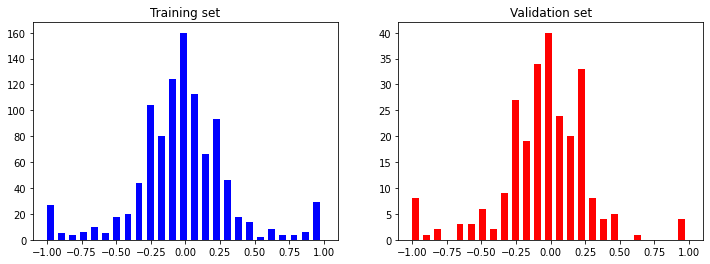

In [ ]:
# we want to ensure that both data sets have a uniform distribution of steering angles
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
######################################
# NEW CELL FOR DATA AUG
####################################

def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3)) # no zoom out. zoom in up to 30%
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'zoomed_image')

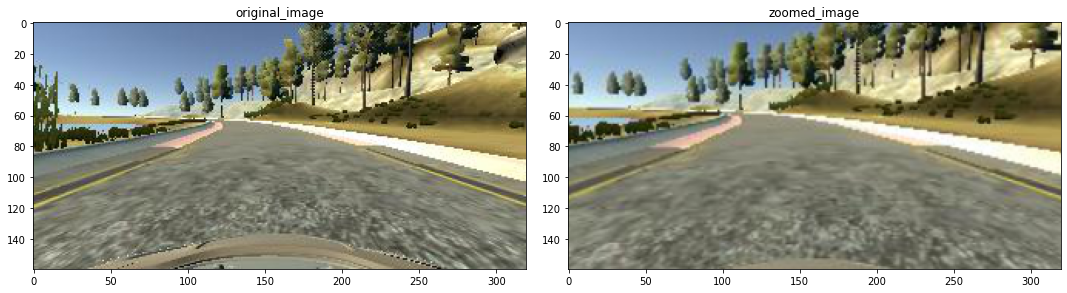

In [ ]:
# let us vesulize this augmentation
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original_image')
axes[1].imshow(zoomed_image)
axes[1].set_title('zoomed_image')


In [ ]:
# our 2nd augmentation function
def pan(image):
  pan = iaa.Affine(translate_percent={"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'panned_image')

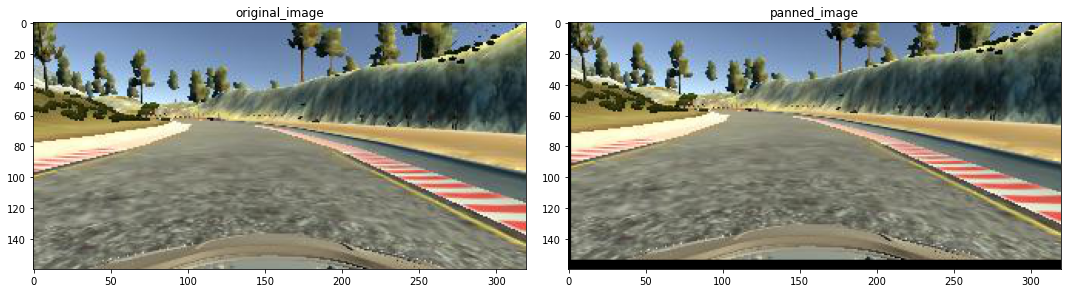

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original_image')
axes[1].imshow(panned_image)
axes[1].set_title('panned_image')

In [ ]:
# 3rd augmentation func.

def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2)) # makes the pixel darker if multiplied with a value less that one and brighter if larger than one
  image = brightness.augment_image(image)
  return image


Text(0.5, 1.0, 'brightness_altered_image')

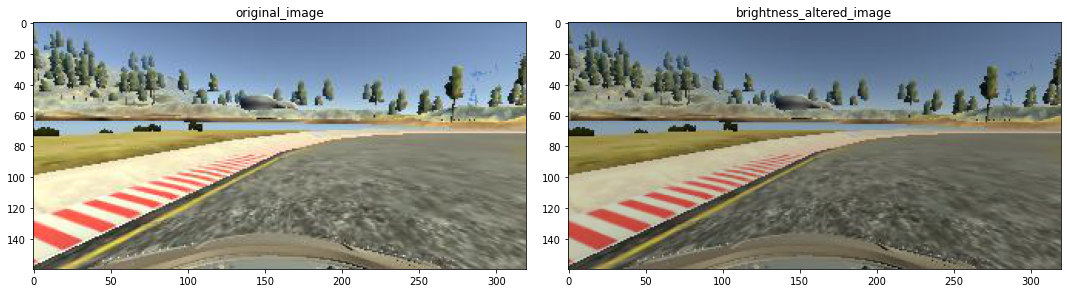

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original_image')
axes[1].imshow(brightness_altered_image)
axes[1].set_title('brightness_altered_image')

In [ ]:

# final aug. tech.
# flipping can provide additional balancing ( balanced distrubution)

def img_random_flip(image, steering_angle):
  image =cv2.flip(image, 1) # 0:vertical flip # 1: hoizantal # -1: combination of both
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped_image - Steering Angle: -0.10184299999999999')

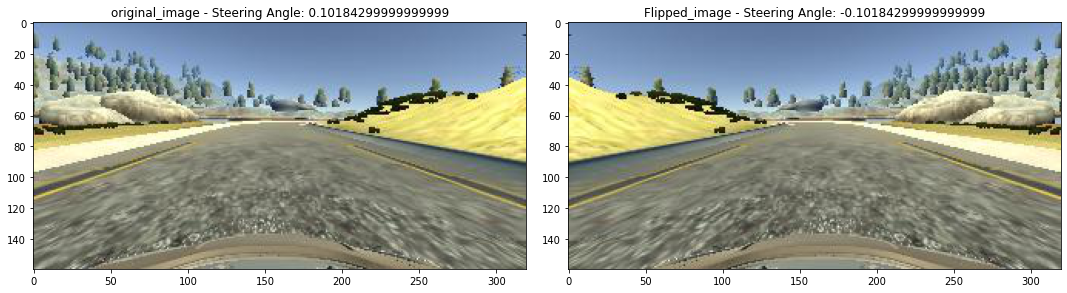

In [ ]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original_image - ' + 'Steering Angle: ' + str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].set_title('Flipped_image - ' + 'Steering Angle: ' + str(flipped_steering_angle))

In [ ]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  # we want to randomize the augmentation
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  
  return image, steering_angle

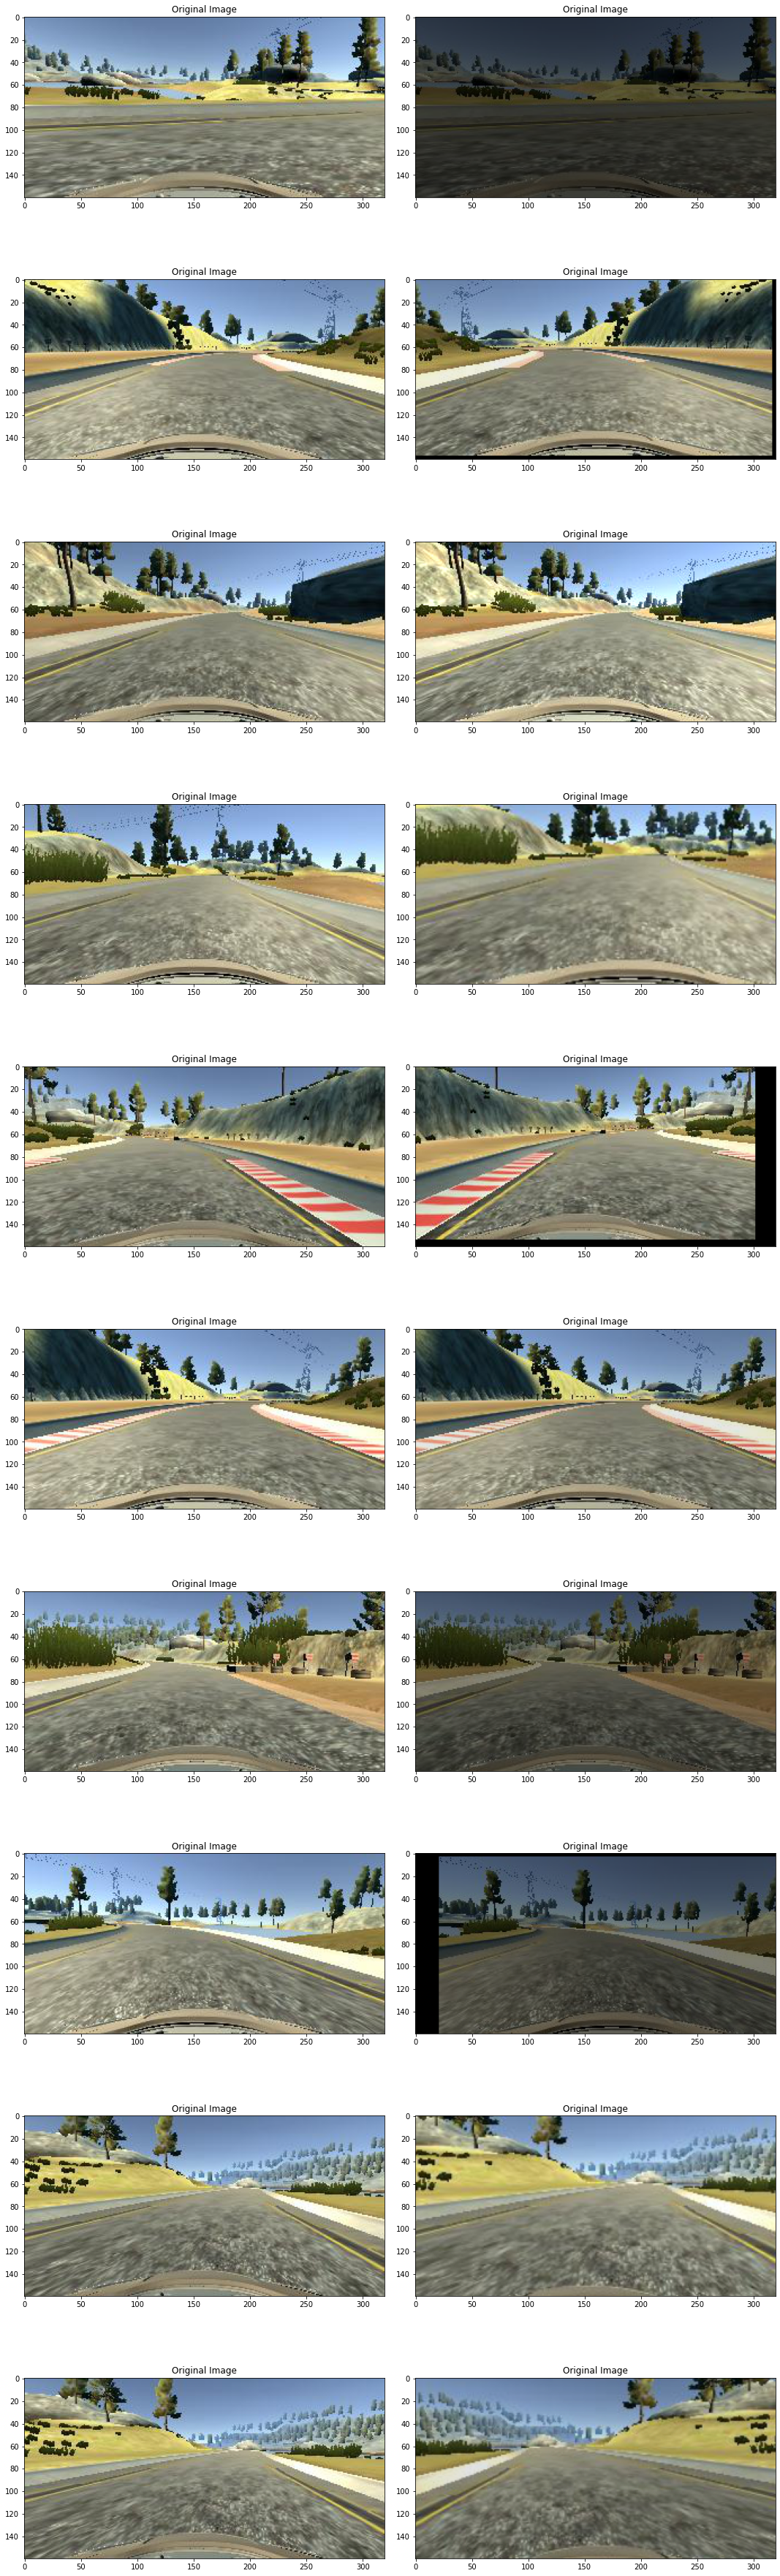

In [ ]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0,len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Original Image')

In [ ]:
# preprocessing data

def img_preprocess(img):
  img = img[60:135, :, :] #crop the sky and car hood 
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # because we will use nvidia model not leNet and they recommend YUV
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66)) # this img is smaller and matches the size in the nvidia model architecture 
  img = img/255
  return img

Text(0.5, 1.0, 'preprocessed_image')

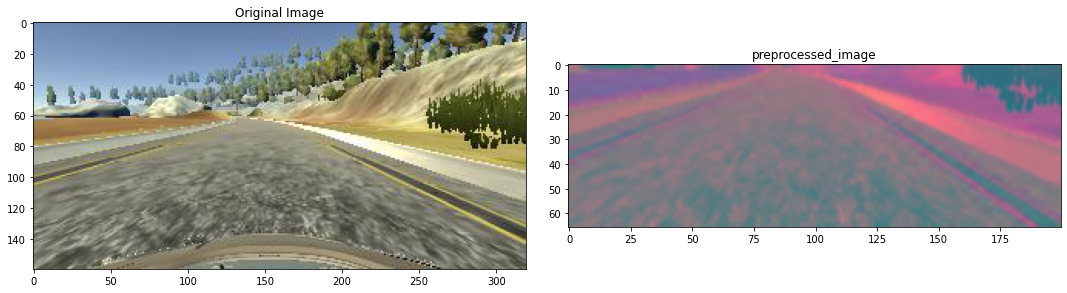

In [ ]:
# let us visulize our original images along with the preprocessed images 

image = image_paths[100] # random image
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed_image')

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining): # is training: T for training data , F for validation data

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))
    

Text(0.5, 1.0, 'Validation image')

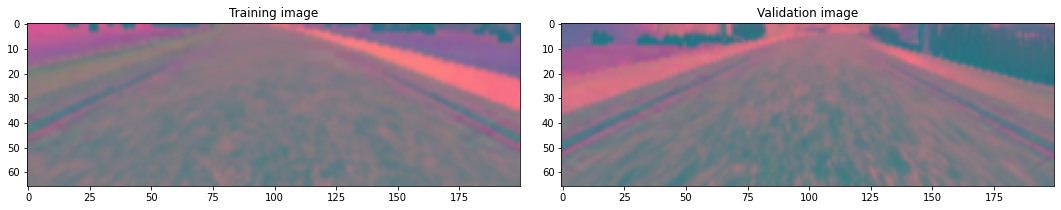

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1)) # next is to ask for the next batch of images from our batch_generator
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0)) # notice that we are asking for 1 batch only 

fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training image')
axes[1].imshow(x_valid_gen[0])
axes[1].set_title('Validation image')

In [ ]:
# notice that in the beginning the model was not trained! each epoch had the same resulting loss ! 
# this means our model is bad ! so to solve it we need to change the activation function from relu to elu
# the relu functions dies when the value is less than zero ! so it cannot be trained but elu does not
# let us train new model
# also we will add dropout layers to avoid overfitting

def nvidia_model2():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66,200,3), activation='relu'))
  model.add(Convolution2D(36, 5, 5,subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48, 5, 5,subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))

  model.add(Convolution2D(64, 3, 3, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1))

  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [ ]:
model2 = nvidia_model2()
print(model2.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  if __name__ == '__main__':



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)            

In [ ]:
history2 = model2.fit_generator(batch_generator(X_train, y_train, 100, 1),steps_per_epoch=300,epochs=10,validation_data=batch_generator(X_valid, y_valid, 100, 0),validation_steps = 200,verbose =1,shuffle = 1)

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

In [ ]:
# now we want to save our model
#model2.save('model.h5')

In [ ]:
# to reuse the model: from google.colab import files
#files.download('model.h5')